env urban

csf3 junjie

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr
import gc
import pickle
from tqdm import tqdm
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import shap
print("AutoML version:", AutoML.__version__)

AutoML version: 2.1.1


In [2]:
input_feature = ['CAM', 'surf', 'loc']
start_year = '2061'
end_year = '2070'


# ====== data prep ======
# for loading CESM-LE data
def get_merge_member(start_year, end_year, parquet_save_path):
    df_tmp_ls = []
    for member_id in range(3, 34):
        member = (str(member_id).zfill(3))
        df_tmp_ls.append(pd.read_parquet(parquet_save_path + "train/" + member + "_"\
                            + start_year + "_" + end_year + ".parquet.gzip", engine="fastparquet"))
    return pd.concat(df_tmp_ls)


def get_trainning_set(input_feature, start_year, end_year):

    urban_surf_path = "/home/zhonghua/UrbFLAM/urban_params/urban_surface.parquet.gzip"
    parquet_save_path = "/home/zhonghua/UrbFLAM//urban_params/urban_LE_random_split/"
    feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }

    feature_cat =  input_feature # process from input to list
    feature_join = "_".join(feature_cat) # for file name
    feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features
    print(feature_ls)

    # load data
    urban_LE = get_merge_member(start_year, end_year, parquet_save_path)
    urban_surf = pd.read_parquet(urban_surf_path, engine="fastparquet").reset_index()
    # merge data
    train = pd.merge(urban_LE, urban_surf, on = ["lat","lon"], how = "inner")
    # check if we merge the data successfully
    assert urban_LE.shape[0] == train.shape[0]
    del urban_LE, urban_surf
    gc.collect()

    return train

def get_shap_importance(model,training_set):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(training_set)
    return np.absolute(shap_values).mean(axis=0)[0:training_set.shape[1]]



def get_model_ranking_score(feature_cat, model_name, start_year, training_set):
    feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }
    
    end_year = str(int(start_year)+9)

    scf3home = '/home/zhonghua/UrbFLAM/urban_params'
    parquet_save_path = scf3home + "/urban_LE_random_split/"

    feature_join = "_".join(feature_cat) # for file name
    feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features
    model_pkl_save_path = parquet_save_path+model_name+"/"+start_year+"_"+end_year+"_"+feature_join+".pkl"
#     print("model location:", model_pkl_save_path)
    
    with open(model_pkl_save_path, 'rb') as f:
        automl = pickle.load(f)
    #     print(automl.model.estimator)
        if model_name == "xgboost":
            model = automl.model.estimator.get_booster()
        model = automl.model.estimator
        print(automl.model.estimator)
        #best_model_name = automl._best_estimator

    shap_importance = get_shap_importance(model,training_set)

    df_feature = pd.DataFrame({"features":feature_ls,
                                   "importance":shap_importance})

    colname = model_name+"_"+start_year
    
    df_feature[colname] = df_feature["importance"].rank(ascending=True)
   
    return model_pkl_save_path, df_feature[["features",colname]]

## show elements of the obejct

In [3]:
%%time
feature_cat=["CAM","surf","loc"]; model_name="FLAML"; start_year="2006"
#model_pkl_save_path, df_importance = get_model_ranking_score(feature_cat, model_name, start_year)
model_pkl_save_path = '../urban_LE_random_split/FLAML/2006_2015_CAM_surf_loc.pkl'
with open(model_pkl_save_path, 'rb') as f:
    print(model_pkl_save_path)
    automl = pickle.load(f)

print(automl.model.estimator)
dir(automl)


../urban_LE_random_split/FLAML/2006_2015_CAM_surf_loc.pkl
LGBMRegressor(colsample_bytree=0.5389295843070607,
              learning_rate=0.02247347321035838, max_bin=1023,
              min_child_samples=9, n_estimators=32767, num_leaves=495,
              reg_alpha=0.00706357318094864, reg_lambda=0.04950682421772725,
              verbose=-1)
CPU times: user 40.9 s, sys: 12.6 s, total: 53.5 s
Wall time: 5.91 s


['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__version__',
 '__weakref__',
 '_active_estimators',
 '_auto_augment',
 '_best_estimator',
 '_best_iteration',
 '_check_feature_names',
 '_check_n_features',
 '_config_history',
 '_decide_eval_method',
 '_decide_split_type',
 '_df',
 '_early_stop',
 '_eci',
 '_ensemble',
 '_estimator_index',
 '_estimator_type',
 '_fullsize_reached',
 '_get_param_names',
 '_get_tags',
 '_hpo_method',
 '_iter_per_learner',
 '_iter_per_learner_fullsize',
 '_label_transformer',
 '_learner_selector',
 '_log_trial',
 '_log_type',
 '_max_iter',
 '_max_iter_per_learner',
 '_mem_thres',
 '_metric_constraints',
 '_min_sample_size',
 '_more_tags',
 '_n_concurrent_trials',
 '_ndim',
 '_nrow',
 '_pred_time_limit',
 '_prepare_data',
 '_preprocess',
 '_random',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_retrain_in_budget',
 '_retrained_config',
 '_sample',
 '_search',
 '_search_parallel',
 '_search_sequential',
 '_search_states',
 '_seed',
 '_select_estimator',
 '_selected',
 '_settings',
 '_split_type',
 '_start_time_flag',
 '_state',
 '_time_taken_best_iter',
 '_track_iter',
 '_trained_estimator',
 '_training_log',
 '_transformer',
 '_use_ray',
 '_validate_data',
 '_validate_ts_data',
 '_warn_threshold',
 'add_learner',
 'best_config',
 'best_config_per_estimator',
 'best_config_train_time',
 'best_estimator',
 'best_iteration',
 'best_loss',
 'best_loss_per_estimator',
 'best_model_for_estimator',
 'best_result',
 'cat_hp_cost',
 'classes_',
 'config_history',
 'data_size_full',
 'estimator_list',
 'fit',
 'get_estimator_from_log',
 'get_params',
 'low_cost_partial_config',
 'max_resource',
 'metric_constraints',
 'metrics_for_best_config',
 'min_resource',
 'model',
 'modelcount',
 'n_features_in_',
 'pickle',
 'points_to_evaluate',
 'predict',
 'predict_proba',
 'resource_attr',
 'retrain_from_log',
 'save_best_config',
 'score',
 'search_space',
 'set_params',
 'split_ratio',
 'time_to_find_best_model',
 'trainable',
 'verbose']

In [4]:
feature_cat=["CAM","surf","loc"]
feature_cat=["CAM","surf","loc"]

feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }
feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features
training_set = get_trainning_set(feature_cat, "2006", '2015')[feature_ls]
training_set

['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT', 'CANYON_HWR', 'EM_IMPROAD', 'EM_PERROAD', 'EM_ROOF', 'EM_WALL', 'HT_ROOF', 'THICK_ROOF', 'THICK_WALL', 'T_BUILDING_MAX', 'T_BUILDING_MIN', 'WTLUNIT_ROOF', 'WTROAD_PERV', 'NLEV_IMPROAD', 'PCT_URBAN', 'ALB_IMPROAD', 'ALB_PERROAD', 'ALB_ROOF', 'ALB_WALL', 'TK_ROOF', 'TK_WALL', 'CV_ROOF', 'CV_WALL', 'TK_IMPROAD_0', 'CV_IMPROAD_0', 'TK_IMPROAD_1', 'CV_IMPROAD_1', 'lat', 'lon']


,FLNS,FSNS,PRECT,PRSN,QBOT,TREFHT,UBOT,VBOT,CANYON_HWR,EM_IMPROAD,...,TK_ROOF,TK_WALL,CV_ROOF,CV_WALL,TK_IMPROAD_0,CV_IMPROAD_0,TK_IMPROAD_1,CV_IMPROAD_1,lat,lon
0,53.756626,39.101246,3.387997e-09,3.103889e-09,0.003002,273.944824,-4.995862,2.697454,0.850000,0.91,...,0.184568,0.939309,1162448.125,1.044529e+06,1.67,2060470.625,0.56,1712294.75,53.246075,7.5
1,41.671654,43.362343,1.402574e-08,2.106027e-16,0.004280,278.834106,5.220407,6.277958,0.850000,0.91,...,0.184568,0.939309,1162448.125,1.044529e+06,1.67,2060470.625,0.56,1712294.75,53.246075,7.5
2,13.436749,35.440952,3.306169e-10,1.810511e-16,0.004166,277.587250,-0.116518,-3.803710,0.850000,0.91,...,0.184568,0.939309,1162448.125,1.044529e+06,1.67,2060470.625,0.56,1712294.75,53.246075,7.5
3,1.588632,5.894991,8.083923e-08,0.000000e+00,0.006819,282.860291,9.860652,5.418288,0.850000,0.91,...,0.184568,0.939309,1162448.125,1.044529e+06,1.67,2060470.625,0.56,1712294.75,53.246075,7.5
4,12.181718,13.738743,4.590168e-09,0.000000e+00,0.008645,286.769318,-0.962314,1.063155,0.850000,0.91,...,0.184568,0.939309,1162448.125,1.044529e+06,1.67,2060470.625,0.56,1712294.75,53.246075,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16737825,31.875000,45.855469,1.780971e-13,0.000000e+00,0.007996,293.500000,-3.640625,-0.828125,0.666667,0.91,...,0.144647,1.442709,967411.000,9.600517e+05,0.64,1787100.375,0.36,1545600.00,18.376963,97.5
16737826,75.000000,194.042969,7.602985e-11,-1.515654e-25,0.009521,293.375000,-2.203125,-0.730469,0.666667,0.91,...,0.144647,1.442709,967411.000,9.600517e+05,0.64,1787100.375,0.36,1545600.00,18.376963,97.5
16737827,39.500000,212.132812,2.470233e-08,0.000000e+00,0.016602,298.000000,2.203125,0.097168,0.666667,0.91,...,0.144647,1.442709,967411.000,9.600517e+05,0.64,1787100.375,0.36,1545600.00,18.376963,97.5
16737828,101.500000,279.312500,4.388160e-18,0.000000e+00,0.006653,297.500000,2.203125,0.507812,0.666667,0.91,...,0.144647,1.442709,967411.000,9.600517e+05,0.64,1787100.375,0.36,1545600.00,18.376963,97.5


In [5]:
explainer = shap.TreeExplainer(automl.model.estimator)


In [6]:
training_set1 = training_set.groupby(['lat','lon']).sample(1, random_state=1).reset_index()[feature_ls]
shap_values = explainer.shap_values(training_set1)
shap_values.mean(axis=0)

array([ 1.55866720e-02,  9.26434854e-03,  3.74919817e-02,  1.23427726e-01,
        2.59809410e-01, -5.69466889e-01,  1.02097087e-02,  3.35120695e-03,
        5.26048782e-03,  4.89526952e-04,  0.00000000e+00,  3.16913069e-03,
        2.04307627e-03,  4.39939289e-03,  1.08416347e-03,  1.42969761e-02,
       -4.66591039e-03,  1.56472352e-02, -9.48962931e-03,  6.65000729e-03,
        2.62909266e-04,  5.24931926e-03,  1.53963989e-03,  0.00000000e+00,
        1.23587417e-02,  1.52655159e-02,  5.25876050e-03,  3.97681721e-03,
        6.79963198e-03,  2.63615239e-03, -4.16753155e-03,  3.06165506e-03,
       -3.70286812e-03, -2.83921881e-03,  1.22181219e-01, -4.07227535e-02,
        2.94892759e+02])

In [26]:
training_set1.shape[1]

36

In [9]:
len(feature_ls)

36

In [25]:
shap_values.mean(axis=0)[0:37]

array([ 1.55866720e-02,  9.26434854e-03,  3.74919817e-02,  1.23427726e-01,
        2.59809410e-01, -5.69466889e-01,  1.02097087e-02,  3.35120695e-03,
        5.26048782e-03,  4.89526952e-04,  0.00000000e+00,  3.16913069e-03,
        2.04307627e-03,  4.39939289e-03,  1.08416347e-03,  1.42969761e-02,
       -4.66591039e-03,  1.56472352e-02, -9.48962931e-03,  6.65000729e-03,
        2.62909266e-04,  5.24931926e-03,  1.53963989e-03,  0.00000000e+00,
        1.23587417e-02,  1.52655159e-02,  5.25876050e-03,  3.97681721e-03,
        6.79963198e-03,  2.63615239e-03, -4.16753155e-03,  3.06165506e-03,
       -3.70286812e-03, -2.83921881e-03,  1.22181219e-01, -4.07227535e-02,
        2.94892759e+02])

## show feature importance of different categories

In [3]:
dd = {
    "cam":['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
    "loc":["lat","lon"],
    "morphological":['CANYON_HWR','HT_ROOF','THICK_ROOF','THICK_WALL','WTLUNIT_ROOF','WTROAD_PERV','PCT_URBAN'],
    "radiative": ['EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL'],
    "thermal":[
        'T_BUILDING_MAX','T_BUILDING_MIN',            
        'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
        'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1',
        'NLEV_IMPROAD']
}

dd_cat = {}
for key in dd:
    for feature in dd[key]:
        dd_cat[feature] = key 

In [4]:
feature_cat=["CAM","surf","loc"]

feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }
feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features

for start_year, end_year in zip(["2006", "2061"], ["2015", "2070"]):
    training_set = get_trainning_set(feature_cat, start_year, end_year)[feature_ls]
    training_set = training_set.groupby(['lat','lon']).sample(1, random_state=1).reset_index()[feature_ls]
    for model_name in ["FLAML", "xgboost"]: #"lgbm", 
        print(start_year)
        print(model_name)
        model_pkl_save_path, df_tmp = get_model_ranking_score(feature_cat, model_name, start_year, training_set)
        if model_name == "FLAML" and start_year == "2006":
            df = df_tmp.copy()
        else:
            df = df.merge(df_tmp, on = "features", how = "outer")
        del df_tmp
        gc.collect()

['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT', 'CANYON_HWR', 'EM_IMPROAD', 'EM_PERROAD', 'EM_ROOF', 'EM_WALL', 'HT_ROOF', 'THICK_ROOF', 'THICK_WALL', 'T_BUILDING_MAX', 'T_BUILDING_MIN', 'WTLUNIT_ROOF', 'WTROAD_PERV', 'NLEV_IMPROAD', 'PCT_URBAN', 'ALB_IMPROAD', 'ALB_PERROAD', 'ALB_ROOF', 'ALB_WALL', 'TK_ROOF', 'TK_WALL', 'CV_ROOF', 'CV_WALL', 'TK_IMPROAD_0', 'CV_IMPROAD_0', 'TK_IMPROAD_1', 'CV_IMPROAD_1', 'lat', 'lon']
2006
FLAML
LGBMRegressor(colsample_bytree=0.5389295843070607,
              learning_rate=0.02247347321035838, max_bin=1023,
              min_child_samples=9, n_estimators=32767, num_leaves=495,
              reg_alpha=0.00706357318094864, reg_lambda=0.04950682421772725,
              verbose=-1)
2006
xgboost
XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.4713847975226029, colsample_bynode=1,
             colsample_bytree=0.9318576757577409, gamma=0, gpu_id=-1,
             grow_policy='lossguide', importance_type='ga

In [5]:
training_set.columns

Index(['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT',
       'CANYON_HWR', 'EM_IMPROAD', 'EM_PERROAD', 'EM_ROOF', 'EM_WALL',
       'HT_ROOF', 'THICK_ROOF', 'THICK_WALL', 'T_BUILDING_MAX',
       'T_BUILDING_MIN', 'WTLUNIT_ROOF', 'WTROAD_PERV', 'NLEV_IMPROAD',
       'PCT_URBAN', 'ALB_IMPROAD', 'ALB_PERROAD', 'ALB_ROOF', 'ALB_WALL',
       'TK_ROOF', 'TK_WALL', 'CV_ROOF', 'CV_WALL', 'TK_IMPROAD_0',
       'CV_IMPROAD_0', 'TK_IMPROAD_1', 'CV_IMPROAD_1', 'lat', 'lon'],
      dtype='object')

In [6]:
df["category"] = df["features"].map(dd_cat)
df.to_csv("./data/feature_importance_shap.csv",index=False)

In [9]:
df_load = pd.read_csv("./data/feature_importance_shap.csv")
df_load

,features,FLAML_2006,xgboost_2006,FLAML_2061,xgboost_2061,category
0,FLNS,32.0,32.0,33.0,34.0,cam
1,FSNS,35.0,35.0,35.0,35.0,cam
2,PRECT,29.0,29.0,29.0,30.0,cam
3,PRSN,33.0,33.0,32.0,25.0,cam
4,QBOT,34.0,34.0,34.0,33.0,cam
5,TREFHT,36.0,36.0,36.0,36.0,cam
6,UBOT,27.0,27.0,27.0,28.0,cam
7,VBOT,26.0,26.0,26.0,27.0,cam
8,CANYON_HWR,24.0,24.0,25.0,24.0,morphological
9,EM_IMPROAD,5.0,5.0,5.0,7.0,radiative


In [3]:
df_load[["features","FLAML_2006","category"]].groupby("category").mean()

,FLAML_2006
category,
cam,31.500000
loc,30.500000
morphological,18.714286
radiative,10.875000
thermal,12.272727


## feature importance for thermal, radiative, morphological

In [2]:
df = pd.read_csv("./data/feature_importance_shap.csv")
df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
df_plot_tmp.columns = ["features","category","model_year","ranking score"]

# split model_year
new = df_plot_tmp["model_year"].str.split("_", expand=True)
df_plot_tmp["model"] = new[0]
df_plot_tmp["year"] = new[1]
df_plot_tmp = df_plot_tmp[df_plot_tmp["model"]!="lgbm"]

df_plot = df_plot_tmp[["features","category","ranking score","model","year"]]
df_plot = df_plot.replace({"xgboost":"XGBoost"})
df_plot = df_plot.replace(["cam","loc","morphological","radiative","thermal"],["CAM", "LOC", "MOR", "RAD", "THM"])

In [3]:
df_plot_tmp.model.unique()

array(['FLAML', 'xgboost'], dtype=object)

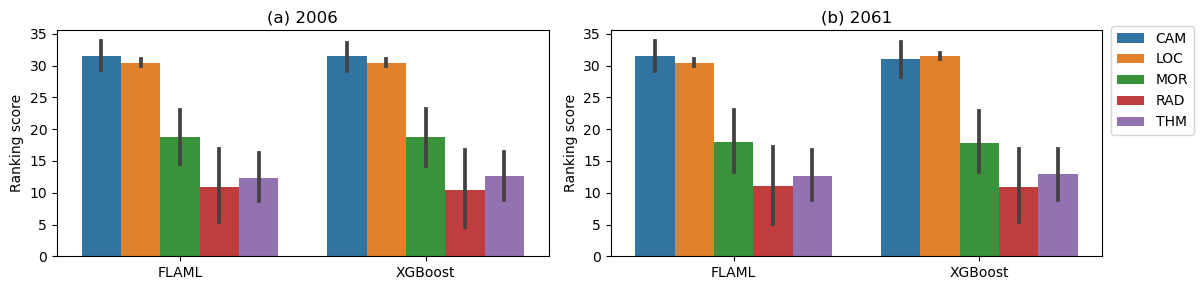

In [4]:
fig = plt.figure(figsize=(12,3))
(ax1, ax2) = fig.subplots(1,2)
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "MOR", "RAD", "THM"],
            data = df_plot[df_plot["year"]=="2006"], ax=ax1)
ax1.legend([],[],frameon=False)
ax1.set_title("(a) 2006")
ax1.set_ylabel("Ranking score")
ax1.set_xlabel("")
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "MOR", "RAD", "THM"],
            data = df_plot[df_plot["year"]=="2061"], ax=ax2)
ax2.legend(ncol=1, bbox_to_anchor=(1.2, 1.05))
ax2.set_title("(b) 2061")
ax2.set_ylabel("Ranking score")
ax2.set_xlabel("")
plt.tight_layout()
fig.savefig('paper_figs/shap_importance_5.pdf', dpi=188)

## feature importance for surf

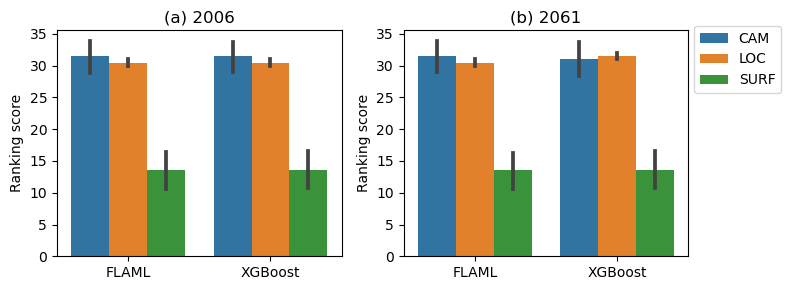

In [14]:
df = pd.read_csv("./data/feature_importance_shap.csv").replace({"thermal":"surf", "radiative":"surf", "morphological":"surf"})
df = df.replace(["cam","loc","surf"],["CAM", "LOC", "SURF"])
df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
df_plot_tmp.columns = ["features","category","model_year","ranking score"]

# split model_year
new = df_plot_tmp["model_year"].str.split("_", expand=True)
df_plot_tmp["model"] = new[0]
df_plot_tmp["year"] = new[1]
df_plot_tmp = df_plot_tmp.replace({"xgboost":"XGBoost"})
df_plot_tmp = df_plot_tmp[df_plot_tmp["model"]!="lgbm"]

df_plot = df_plot_tmp[["features","category","ranking score","model","year"]]


fig = plt.figure(figsize=(8,3))
(ax1, ax2) = fig.subplots(1,2)
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "SURF"],
            data = df_plot[df_plot["year"]=="2006"], ax=ax1)
ax1.legend([],[],frameon=False)
ax1.set_title("(a) 2006")
ax1.set_ylabel("Ranking score")
ax1.set_xlabel("")
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "SURF"],
            data = df_plot[df_plot["year"]=="2061"], ax=ax2)
ax2.legend(ncol=1, bbox_to_anchor=(1.35, 1.05))
ax2.set_title("(b) 2061")
ax2.set_ylabel("Ranking score")
ax2.set_xlabel("")
plt.tight_layout()
fig.savefig('paper_figs/shap_importance_3.pdf', dpi=188)

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

file = "./data/feature_importance_shap_no_ranking.csv"

df = pd.read_csv(file)

df

,features,FLAML_2006,FLAML_2006_std,xgboost_2006,xgboost_2006_std,FLAML_2061,FLAML_2061_std,xgboost_2061,xgboost_2061_std,category
0,FLNS,0.015587,0.606746,-5.233604e-02,0.551825,0.000858,0.572063,-0.060300,0.520529,cam
1,FSNS,0.009264,1.166976,1.799916e-03,1.432439,0.010736,1.265162,0.015592,1.074013,cam
2,PRECT,0.037492,0.229514,1.690576e-02,0.231386,0.044188,0.255667,0.014172,0.253717,cam
3,PRSN,0.123428,0.796887,1.903394e-01,1.041043,0.099382,0.484008,0.052746,0.125937,cam
4,QBOT,0.259809,1.027012,2.149757e-01,1.131929,0.190150,0.866393,0.218844,0.477234,cam
5,TREFHT,-0.569467,8.419466,-4.219470e-01,8.461426,-0.381900,8.393990,-0.248030,10.185100,cam
6,UBOT,0.010210,0.187111,1.184779e-02,0.194998,0.010800,0.207060,0.010761,0.223802,cam
7,VBOT,0.003351,0.181562,7.202157e-03,0.185977,0.002648,0.194883,0.007531,0.205113,cam
8,CANYON_HWR,0.005260,0.092486,8.198314e-03,0.087321,0.004760,0.100445,0.009825,0.095810,morphological
9,EM_IMPROAD,0.000490,0.013491,3.324448e-04,0.012974,0.001567,0.014206,-0.001243,0.010758,radiative


In [30]:
from scipy.stats import t

def t_test(sample_mean, t_std):
    # 样本均值、样本标准差和样本个数
    sample_mean = sample_mean  # 你的样本均值
    sample_size = 4439 # 你的样本个数
    sample_std =  ((t_std**2)*sample_mean/(sample_mean-1))**0.5 # 你的样本标准差
    # 置信水平（例如，95%）
    confidence_level = 0.90

    # 计算 t 分布的临界值
    t_critical = t.ppf((1 + confidence_level) / 2, df=sample_size - 1)

    # 计算置信区间
    margin_of_error = t_critical * (sample_std / (sample_size ** 0.5))
    confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

    # 判断零假设的值是否在置信区间内
    null_hypothesis_value = 0
    if confidence_interval[0] <= null_hypothesis_value <= confidence_interval[1]:
        return True
    else:
        return False

df["t_test_2006"] = df.apply(lambda x: t_test(x["FLAML_2006"], x["FLAML_2006_std"]), axis=1)
df["t_test_2061"] = df.apply(lambda x: t_test(x["FLAML_2061"], x["FLAML_2061_std"]), axis=1)

In [31]:
df = df.drop(["xgboost_2006","xgboost_2061","xgboost_2006_std","xgboost_2061_std"], axis=1)

df.round(2)

,features,FLAML_2006,FLAML_2006_std,FLAML_2061,FLAML_2061_std,category,t_test_2006,t_test_2061
0,FLNS,0.02,0.61,0.00,0.57,cam,False,False
1,FSNS,0.01,1.17,0.01,1.27,cam,False,False
2,PRECT,0.04,0.23,0.04,0.26,cam,False,False
3,PRSN,0.12,0.80,0.10,0.48,cam,False,False
4,QBOT,0.26,1.03,0.19,0.87,cam,False,False
5,TREFHT,-0.57,8.42,-0.38,8.39,cam,False,False
6,UBOT,0.01,0.19,0.01,0.21,cam,False,False
7,VBOT,0.00,0.18,0.00,0.19,cam,False,False
8,CANYON_HWR,0.01,0.09,0.00,0.10,morphological,False,False
9,EM_IMPROAD,0.00,0.01,0.00,0.01,radiative,False,False


In [32]:
df.to_csv("./data/feature_importance_shap_no_ranking_test.csv", index=False)